<a href="https://colab.research.google.com/github/fbagire/sales_predict/blob/deepLearning/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install -q mlflow dvc

In [28]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api
import mlflow
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import joblib

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!cp -r /content/drive/MyDrive/Github/sales_predict/logs .

In [31]:
!cp /content/drive/MyDrive/Github/sales_predict/myscripts/logger_comb.py .
!cp /content/drive/MyDrive/Github/sales_predict/myscripts/modelprep.py .
!cp /content/drive/MyDrive/Github/sales_predict/myscripts/preprocess_data.py .

In [32]:
import preprocess_data
import modelprep

In [26]:
train_df=pd.read_csv('/content/drive/MyDrive/Github/sales_predict/data/train_model.csv')
test_df=pd.read_csv('/content/drive/MyDrive/Github/sales_predict/data/test_model.csv')

In [33]:
importlib.reload(modelprep)
importlib.reload(preprocess_data)

<module 'preprocess_data' from '/content/preprocess_data.py'>

In [34]:
model_prep = modelprep.Modeller(train_df)

In [35]:
X_train, X_val, y_train, y_val = model_prep.split_data()

In [36]:
def fetch_logged_data(run_id):
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

In [37]:
estimators = 25
depth = 15
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('rf_regressor',
                      RandomForestRegressor(n_estimators=estimators,
                                            max_depth=depth,
                                            min_samples_split=2,
                                            min_samples_leaf=1))])

In [38]:
val='validation_'

In [39]:
mlflow.set_experiment('sales_predict')
mlflow.sklearn.autolog()

with mlflow.start_run() as run:

    rf_model = pipeline.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    mse, rmse, r2 = model_prep.error_calculate(y_val, y_pred)
    mlflow.log_metrics({val + "mse": mse, val + 'rmse': rmse, val + 'r2': r2},step=1)
    mlflow.sklearn.log_model(rf_model, "Regressor model")

2022/08/07 17:32:08 INFO mlflow.tracking.fluent: Experiment with name 'sales_predict' does not exist. Creating a new experiment.
2022/08/07 17:34:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp7748te37/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==1.3.0']. Set logging level to DEBUG to see the full traceback.


In [40]:
params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

In [41]:
#Model serializing and saving
#creating a file name using the now timestamp
mdl_tmp = '/content/drive/MyDrive/Github/sales_predict/models/' + str(
    datetime.now().strftime("%d-%m-%Y-%H-%M-%S")) + '.pkl'
joblib.dump(rf_model, mdl_tmp)

['/content/drive/MyDrive/Github/sales_predict/models/07-08-2022-17-34-06.pkl']

**Feature Importance**

Displayin top 10

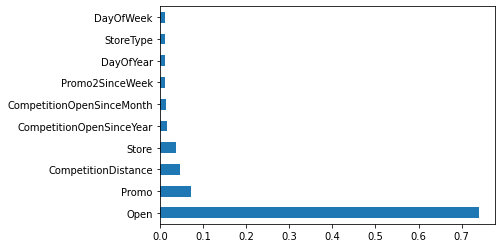

In [42]:
model_prep.feature_importance(pipeline.steps[1][1],x_train=X_train)

## Deep Learning

In [43]:
# Create a timeseries of timeseries Sales
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [44]:
# load original data
# git_rev="214d629a7f3ab08d36c1abb773b0fecf2d78a6c3"

In [45]:
train_og=train_df=pd.read_csv('/content/drive/MyDrive/Github/sales_predict/data/train.csv')
# test_df=pd.read_csv('/content/drive/MyDrive/Github/sales_predict/data/test_model.csv')

In [46]:
train_og['Date']=pd.to_datetime(train_og['Date'])

In [47]:
sales_ts=train_og[['Date','Sales']]

In [48]:
# To make a timeseries we can group the data we have by their frequency which is daily 
sales_ts=sales_ts.groupby(by='Date').mean()

In [49]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
from statsmodels.tsa.stattools import adfuller, acf, pacf

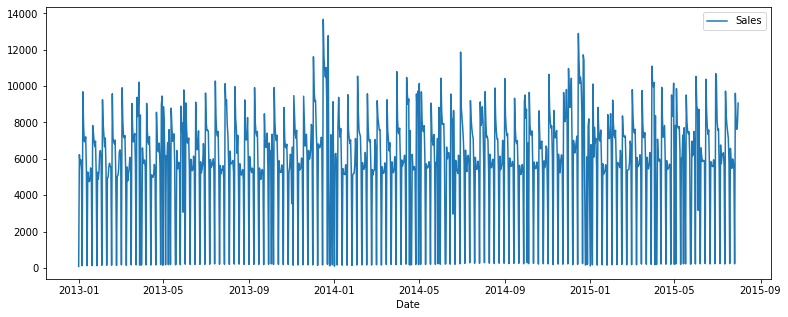

In [50]:
plt.figure(figsize=(13,5))
_=sns.lineplot(data=sales_ts)

From the figure, visually we can see that the timseries has no trend but has probably some seasonality effect. We shall validate this using statistical model

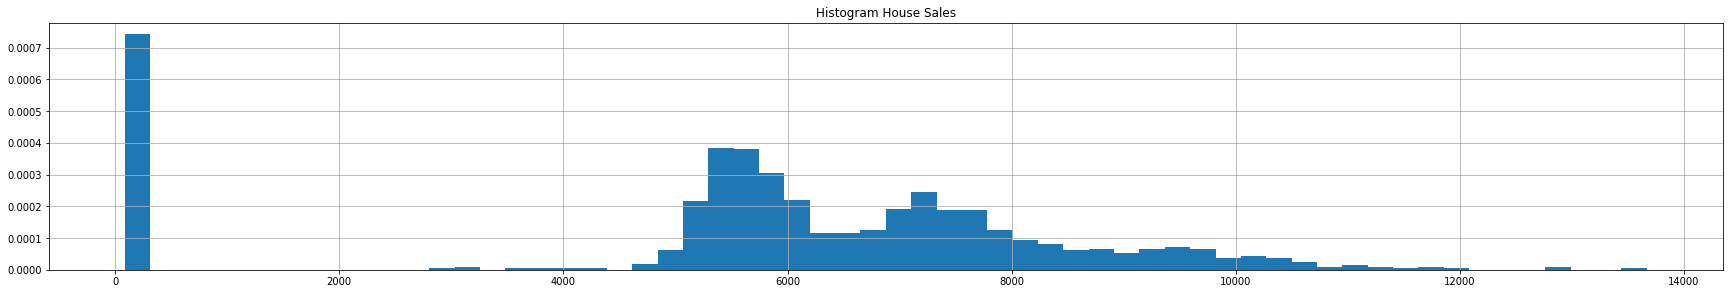

In [51]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(sales_ts.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

In [52]:
prep=preprocess_data.clean_data(sales_ts)

In [53]:
sales_ts=prep.fix_outliers(sales_ts,['Sales'])

### Stationarity

A stationary time series is one whose properties do not depend on the time at which the series is observed. 14. Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.


### Augmented Dickey-Fuller unit root test.

In probability theory and statistics, a unit root is a feature of some stochastic processes (such as random walks) that can cause problems in statistical inference involving time series models. A linear stochastic process has a unit root if 1 is a root of the process's characteristic equation.

One way to determine more objectively whether differencing is required is to use a unit root test.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [54]:
adfResult = adfuller(sales_ts.Sales, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.663614691241004
p-value: 9.258754423607814e-07


As p-value is smaller than 0.05 we reject the null hypothesis (H0) and the data does not have a unit root and is stationary.
if a distribution had been non-stationary we would need to further process the timeseries as it is usually tough to model non-stationary data.

#### Autocorrelations and Partial Autocorrelations Plots.
We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

In [55]:
acfsales = acf(sales_ts.Sales.values, fft=True, nlags=7)
acfsalesNp = np.array(acfsales)

In [56]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Sales")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

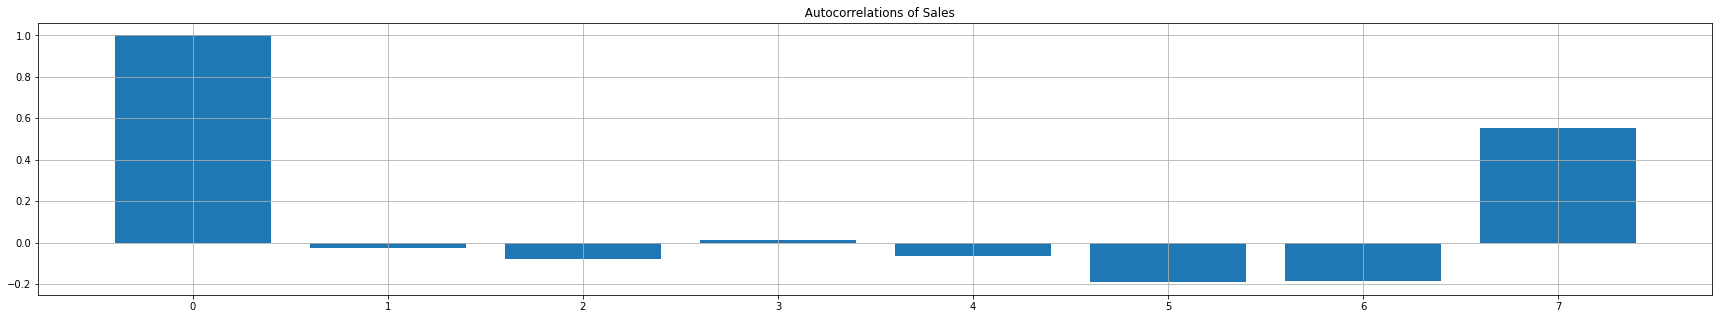

In [57]:
corrPlots(acfsalesNp,'')

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed

In [58]:
sales_scaled=prep.scale_data(sales_ts)

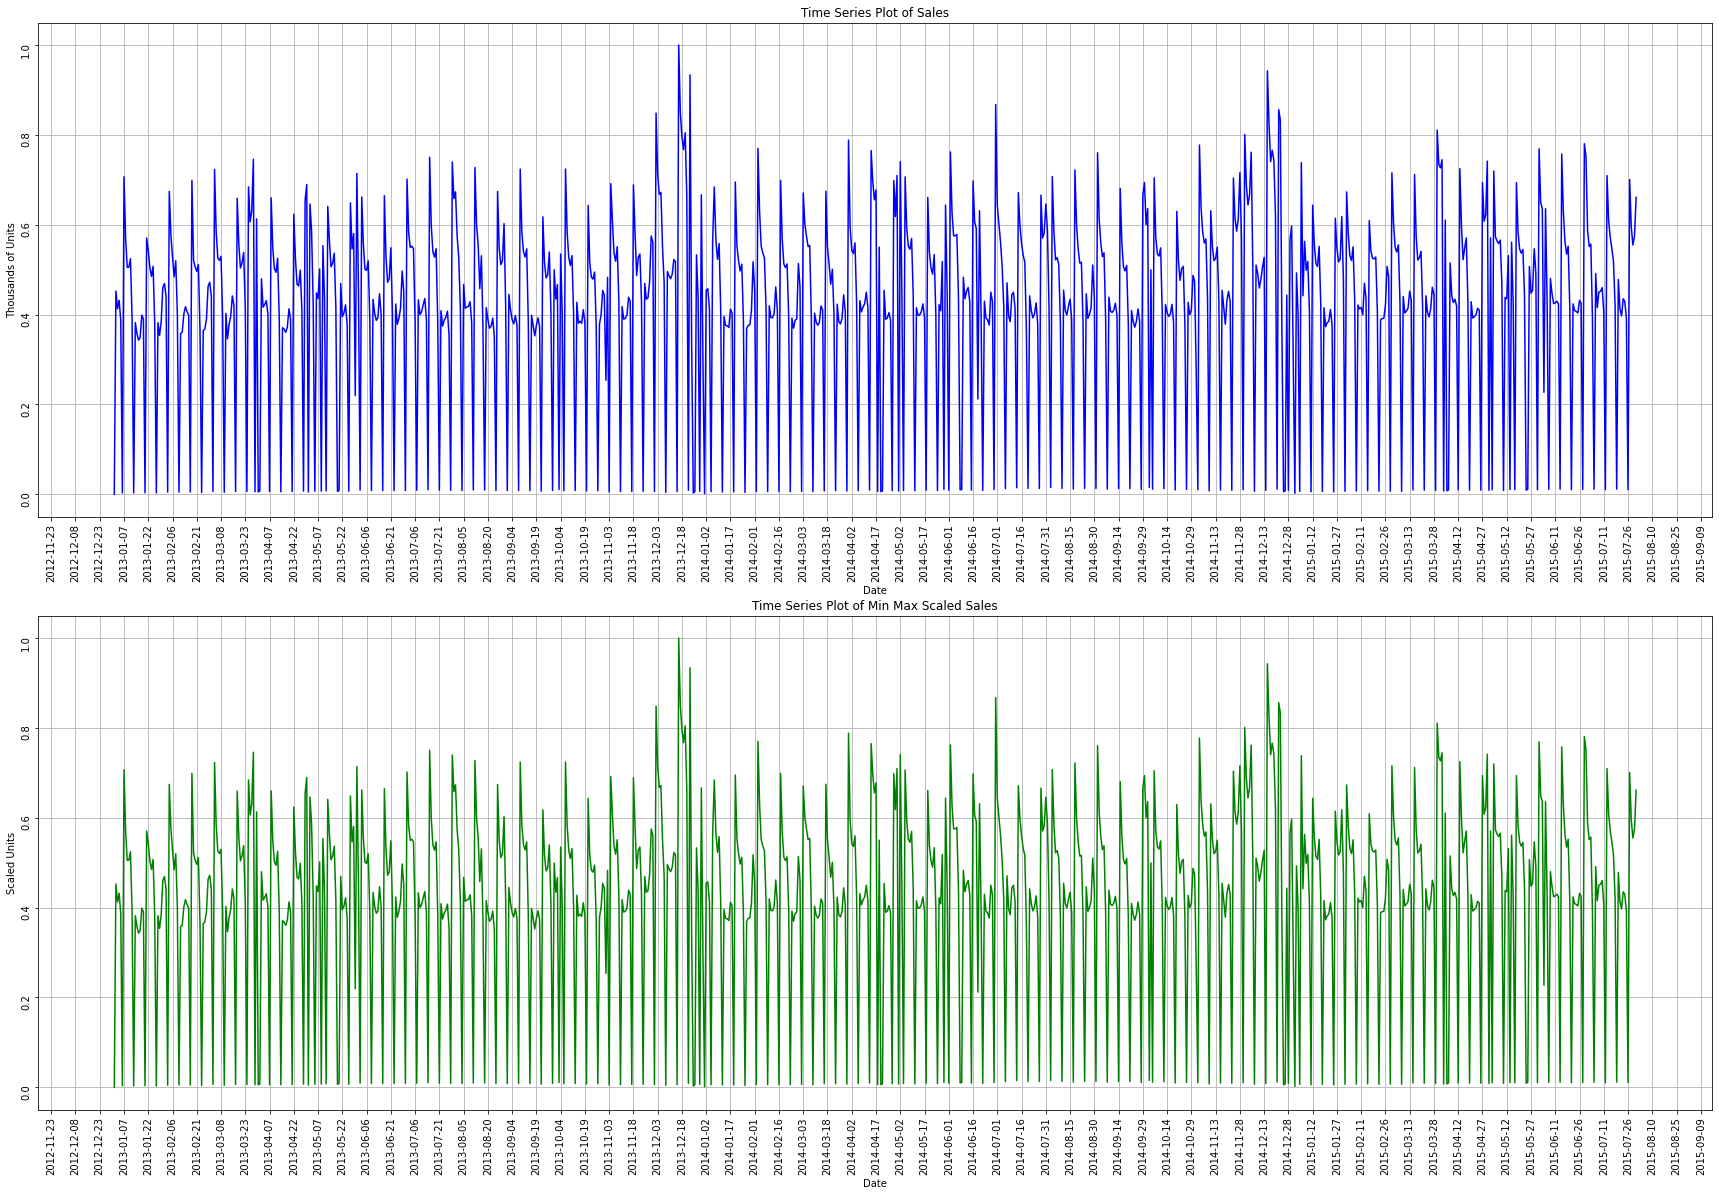

In [59]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sales_ts.index, sales_ts.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(sales_scaled.index, sales_scaled.Sales, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Sales')
ax2.grid(True)
plt.show()

### Separating into a Training and Validation Set Fomat to Use Feed into LSTM

In [60]:
SIZE = len(sales_scaled.Sales)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 120

In [61]:
date_train = sales_ts.index.values[0:BATCH_SIZE]
date_valid = sales_ts.index.values[BATCH_SIZE:]
XTrain = sales_scaled.Sales.values[0:BATCH_SIZE].astype('float32')
XValid = sales_scaled.Sales.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

date_train = np.reshape(date_train, (-1, 1))
date_valid = np.reshape(date_valid, (-1, 1))

print("Shape of the training set date series: ", date_train.shape)
print("Shape of the validation set date series: ", date_valid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [62]:
mlflow.set_experiment('sales_predict')
mlflow.tensorflow.autolog()

In [63]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [64]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(1,), dtype=tf.float32, name=None)>

In [65]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [66]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

The window() method returns a dataset containing windows, where each window is itself represented as a dataset. Something like {{1,2,3,4,5},{6,7,8,9,10},...}, where {...} represents a dataset. But we just want a regular dataset containing tensors: {[1,2,3,4,5],[6,7,8,9,10],...}, where [...] represents a tensor. The flat_map() method returns all the tensors in a nested dataset, after transforming each nested dataset. If we didn't batch, we would get: {1,2,3,4,5,6,7,8,9,10,...}. By batching each window to its full size, we get {[1,2,3,4,5],[6,7,8,9,10],...}

In [67]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [68]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [69]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [70]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

### Define and Estimate the LSTM

In [71]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

The Huber loss is chosen because it is quite robust for non linear regression models and models with non normal errors.

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 8)           320       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 208       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [73]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

2022/08/07 17:34:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '32b867f210534ccda1a35b6ac52cf255', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/120
1/1 [==============================] - 6s 6s/step - loss: 0.1735 - val_loss: 0.1825
Epoch 2/120
1/1 [==============================] - 0s 253ms/step - loss: 0.1679 - val_loss: 0.1768
Epoch 3/120
1/1 [==============================] - 0s 292ms/step - loss: 0.1625 - val_loss: 0.1712
Epoch 4/120
1/1 [==============================] - 0s 239ms/step - loss: 0.1573 - val_loss: 0.1658
Epoch 5/120
1/1 [==============================] - 0s 235ms/step - loss: 0.1522 - val_loss: 0.1606
Epoch 6/120
1/1 [==============================] - 0s 236ms/step - loss: 0.1474 - val_loss: 0.1555
Epoch 7/120
1/1 [==============================] - 0s 243ms/step - loss: 0.1426 - val_loss: 0.1506
Epoch 8/120
1/1 [==============================] - 0s 241ms/step - loss: 0.1381 - val_loss: 0.1459
Epoch 9/120
1/1 [==============================] - 0s 243ms/step - loss: 0.1337 - val_loss: 0.1413
Epoch 10/120
1/1 [==============================] - 0s 231ms/step - loss: 0.1294 - val_loss: 0.1368
Epoch 11/120

INFO:tensorflow:Assets written to: /tmp/tmpkj2r_hg1/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpkj2r_hg1/model/data/model/assets
2022/08/07 17:35:11 WARNING mlflow.utils.requirements_utils: Found tensorflow version (2.8.2+zzzcolab20220719082949) contains a local version label (+zzzcolab20220719082949). MLflow logged a pip requirement for this package as 'tensorflow==2.8.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2022/08/07 17:35:21 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpkj2r_hg1/model, flavor: keras), fall back to return ['tensorflow==2.8.2', 'keras==2.8.0']. Set logging level to DEBUG to see the full traceback.


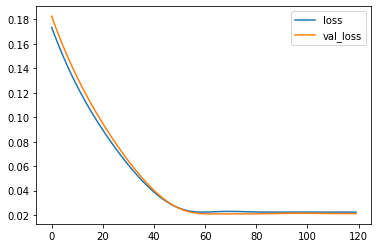

In [74]:
#plotting loss function
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

### forecast the LSTM and find the accuracy of the model on validation set

In [75]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True) 
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(SIZE).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [76]:
scaler=MinMaxScaler().fit(np.array(sales_scaled['Sales']).reshape(-1,1))

In [77]:
Forecast = model_forecast(model, sales_ts.Sales.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

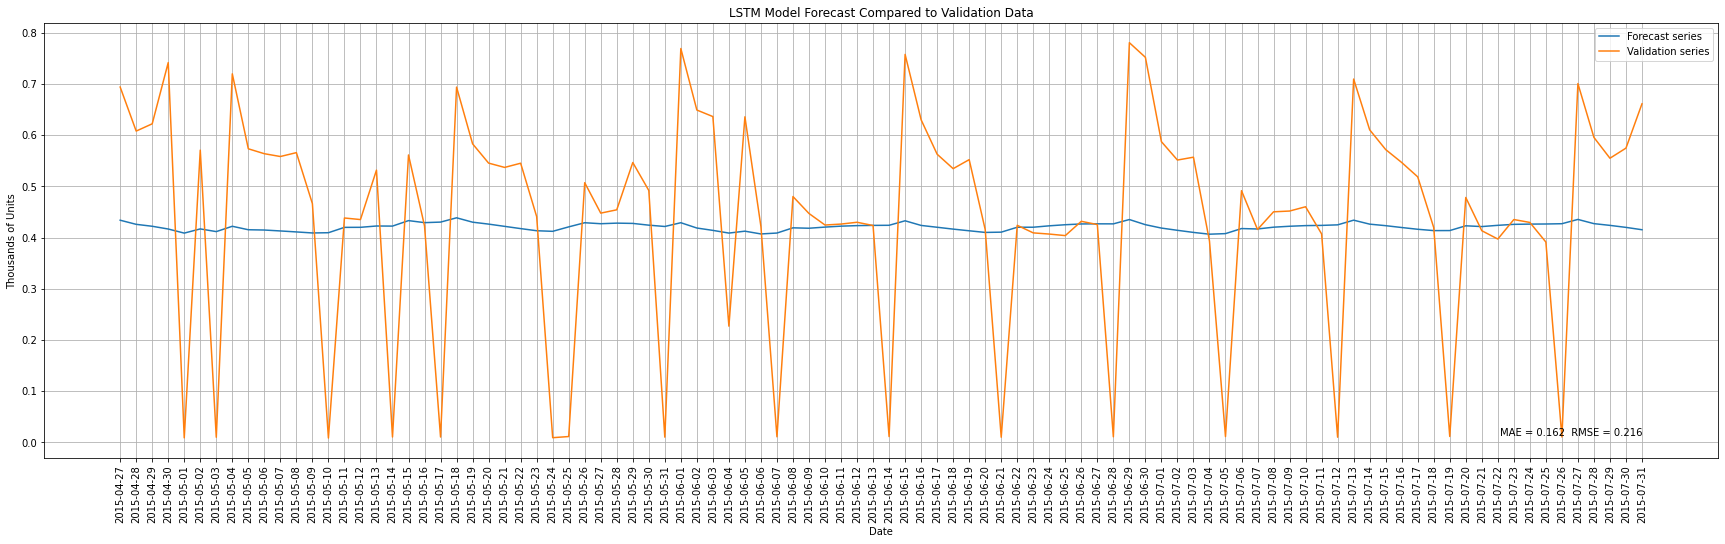

In [78]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(date_valid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(date_valid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(date_valid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()